In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from aif360.algorithms.preprocessing import DisparateImpactRemover
from sklearn.model_selection import train_test_split, cross_val_predict
from aif360.metrics import BinaryLabelDatasetMetric,ClassificationMetric
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, precision_score, recall_score
%matplotlib inline

In [2]:
df2 = pd.read_csv('G:/NYU_MS/Sem2/RDS/predict_corrosive.csv')

In [3]:
df2.head()

,HPFVJD,HPFVTL,HPMQJD,HPMZMQ,HPTLBM,JDJDMQ,JDVBVB,MQJDHP,MQMQHP,MQZJHP,...,MZJDTL,MZUXHP,MZUXJD,MZUXZJ,TLFVMQ,TLZJMZ,UXUXUX,ZJMZBM,ZJMZTL,corrosion
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,False
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,False
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,False
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,False
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,False


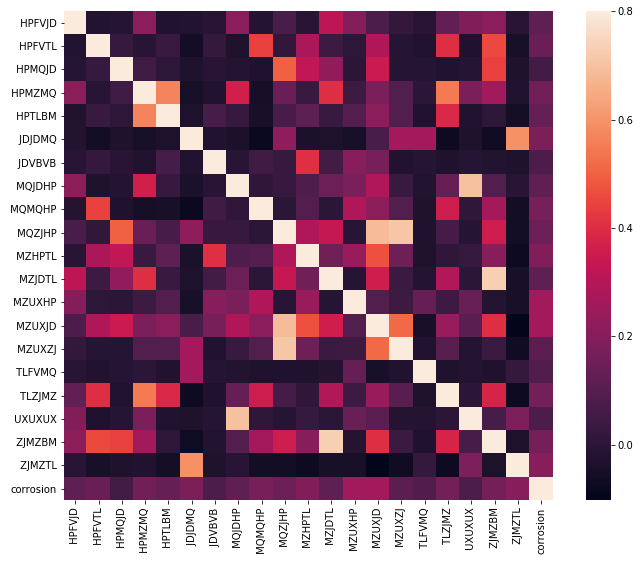

In [4]:
#Covariance Matrix
corrmat = df2.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

In [5]:
#set target and drop from data
df3 = df2.copy()
df4 = df2.copy()
df5 = df2.copy()
target=df2['corrosion']
df2.drop(['corrosion'],axis=1,inplace=True)

X = df2
X_train, X_test, y_train, y_test = train_test_split(X,target, test_size=0.2, random_state=0)
forest = RandomForestClassifier(max_depth=10, random_state=0)
forest.fit(X_train, y_train)

M:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [6]:
print('Mean Accuracy = ',forest.score(X_test,y_test))

Mean Accuracy =  0.8931892435285248


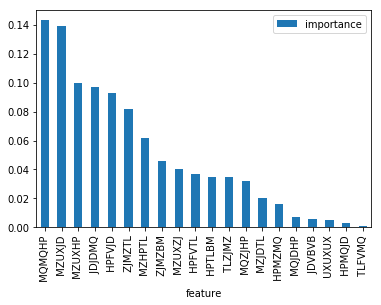

In [7]:
#Important Features
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar();

In [9]:
#Confusion Matrix
predictions = cross_val_predict(forest, X_train, y_train, cv=3)
confusion_matrix(y_train, predictions)

array([[7115,  304],
       [1416, 7079]], dtype=int64)

<div class="alert alert-success" role="alert">
<ul>
    <li>7115 correctly classified as not corrosion</li>
    <li>304 wrongly classified as not corrosion</li>
    <li>1416 people wrongly classified as corrosion</li>
    <li>7079 correctly classified as corrossion</li>
</ul>
</div>

<div class="alert alert-success" role="alert">
Since our ADS tries to determine the presence of Corrosion, metrics such as the **sensitivity** and **specificity** can be used to market the ADS and so we measure the same as,<p>
    \begin{align}
Sensitivity = \frac{True\:Positives}{True\:Positives + False\:Negatives}
\end{align}
    <p>
     \begin{align}
Specificity = \frac{True\:Negatives}{True\:Negatives + False\:Positives}
\end{align}
    </div>

In [10]:
pred = forest.predict(X_test)
cf_mat = confusion_matrix(y_test, pred)
total=sum(sum(cf_mat))

sensitivity = cf_mat[0,0]/(cf_mat[0,0]+cf_mat[1,0])
print('Sensitivity : ', sensitivity )

specificity = cf_mat[1,1]/(cf_mat[1,1]+cf_mat[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.8293023255813954
Specificity :  0.9682886823400766


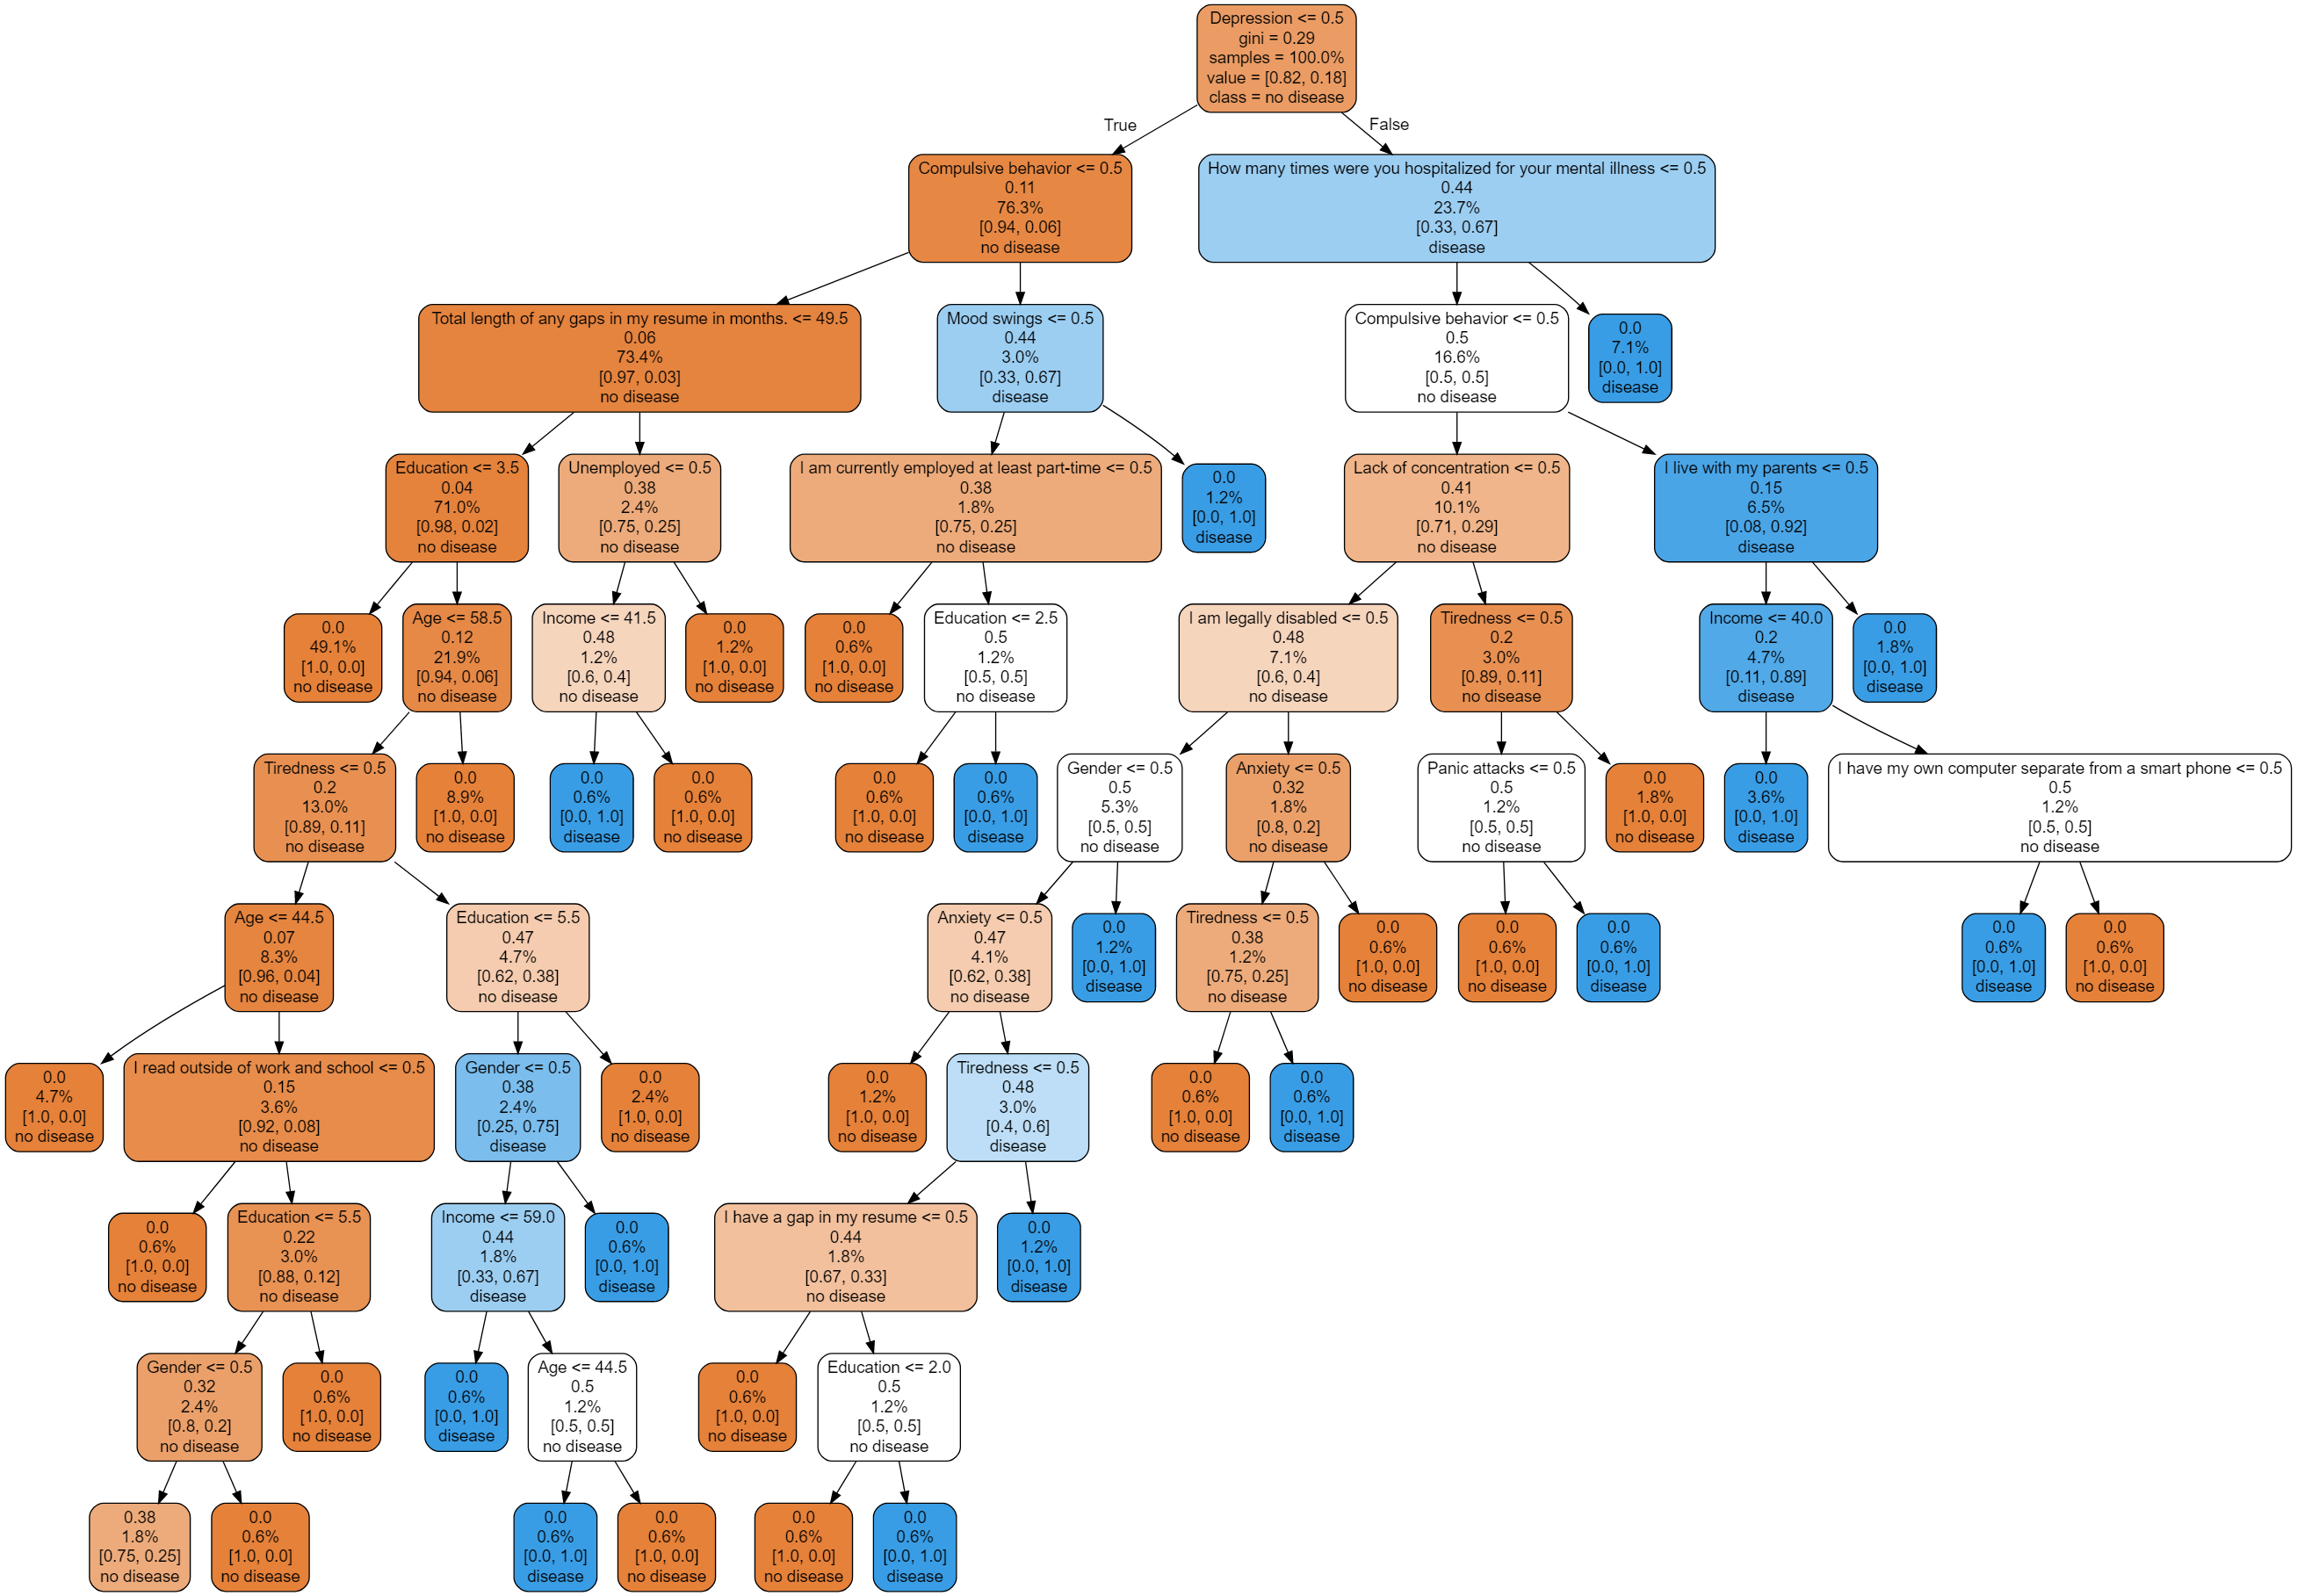

In [11]:
from sklearn.tree import export_graphviz
from IPython.display import Image
from subprocess import call

estimator = forest.estimators_[1]
feature_names = [i for i in X_train.columns]
y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'
y_train_str = y_train_str.values

export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True, 
                label='root',
                precision = 2, filled = True)

call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'],shell=True)
Image(filename = 'tree.png')